In [10]:
from collections import defaultdict
from concurrent.futures import ProcessPoolExecutor
from Bio.SeqIO.FastaIO import SimpleFastaParser as sfp
from Bio import SeqIO, SearchIO, Entrez
import subprocess as sp
import seaborn as sns
import numpy as np
import pandas as pd
import os, glob, math, re, gzip, requests, skbio
import matplotlib.pyplot as plt
from io import StringIO
from scipy import stats

In [11]:
def cmdir(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def scaffold(gene):
    if gene != "None":
        try: return re.search("(.+?)_[0-9]+$", gene).group(1)
        except: print(gene)

def sbatch(name, cpus, cmd):
    return "sbatch -J %s -p serc -t 1- -c %d --mem %dG --wrap '%s'" %(name, cpus, cpus*8, cmd)

In [12]:
rootdir = "/scratch/users/ajaffe/deepeco/"

## read in source data

In [99]:
nr_genomes = pd.read_csv(rootdir + "tables/nonredundant_genome_info.tsv", sep="\t")
nr_genomes.head(2)

,genome,classification,checkm_completeness,checkm_redundancy,primary_cluster,secondary_cluster,representative,scluster_rubisco_set,phylum
0,OceanDNA-b21631,d__Bacteria;p__Patescibacteria;c__Gracilibacte...,82.99,2.48,1,1_0,True,II_III_II_III,d__Bacteria_p__Patescibacteria
1,OceanDNA-b21628,d__Bacteria;p__Patescibacteria;c__Gracilibacte...,79.21,2.09,3,3_0,True,II_III_II_III,d__Bacteria_p__Patescibacteria


In [100]:
pathway_df = pd.read_csv(rootdir + "tables/metabolic_pathway_info.tsv", sep="\t")
pathway_df.head(2)

,function,genome_name,hit_count,hit_total,hit_perc,hit_kos,hit_ids,count_threshold
0,Aerobic Hydrogen Oxidation,MARD_SAMEA2272692_REFG_MMP2272692,1,1,100.0,"NiFe hydrogenase (1d, 1l, 2a)",MARD_MMP2272692_REFG-scaffold_10_10,1
1,Aerobic Hydrogen Oxidation,MARD_SAMEA3214536_REFG_MMP3214536,1,1,100.0,"NiFe hydrogenase (1d, 1l, 2a)",MARD_MMP3214536_REFG-scaffold_171_4,1


In [101]:
genes_df = pd.read_csv(rootdir + "tables/metabolic_gene_info.tsv", sep="\t").fillna("n/a")
genes_df.head(2)

,genome_name,function,gene,present,hit_ids
0,AAA007_O20_contigs_output_clean,Aerobic Hydrogen Oxidation,"NiFe hydrogenase (1d, 1l, 2a)",False,n/a
1,AAA007_O20_contigs_output_clean,Ammonia oxidation,K10944,False,n/a


## reformat

In [102]:
# rubisco assc
rub_assc = genes_df[genes_df["function"].isin(["calvin_benson_bassham"])]#,"pentose_bisphosphate","reductive_hexulose"])]
rub_assc_piv = rub_assc.pivot(index="genome_name", columns="gene", values="present").reset_index()
rub_assc_bin = rub_assc_piv.replace(False, 0).replace(True, 1)
rub_assc_bin.head()

gene,genome_name,fba,fbpase,gapdh,pgk,prk,rpe,rpi,rubisco_small,sbpase,tim,tkl
0,AAA007_O20_contigs_output_clean,1,0,1,1,1,0,0,1,0,0,1
1,AG-311-D23,1,1,1,1,1,1,1,1,1,1,0
2,AG-313-C04,1,0,1,1,1,1,1,1,0,1,1
3,AG-313-L21,0,0,1,0,0,0,1,1,0,1,1
4,AG-319-D09,1,0,1,1,1,1,1,1,0,1,1


In [103]:
# other functional
pathway_df["ones"] = 1
pathway_piv = pathway_df.pivot(index="genome_name", columns="function", values="ones").fillna(0).reset_index()
pathway_piv.head()

function,genome_name,Aerobic Hydrogen Oxidation,Ammonia oxidation,Nitrite oxidation,Sulfide oxidation,Sulfite oxidation,Sulfite production from org. sulfur,Sulfur oxidation,Thiosulfate disproportionation,Thiosulfate oxidation
0,AAA007_O20_contigs_output_clean,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,AG-313-C04,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
2,AG-313-L21,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,AG-319-D09,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
4,AG-333-E20,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [104]:
def assign_label(taxstring):
    
    s = taxstring.split(";")
    if "Proteobacteria" in taxstring:
        return "%s     %s" %(s[2], s[3])
    else: return "%s    %s" %(s[1], s[3])

In [105]:
# merge two sets of pathways
merged_a = rub_assc_bin.merge(pathway_piv, on="genome_name", how="left").fillna(0)
# then add genome metadata
merged = merged_a.merge(nr_genomes[["scluster_rubisco_set", "genome", \
    "classification", "checkm_completeness"]], how="left", left_on="genome_name", right_on="genome").drop("genome", axis=1)
merged["display_name"] = merged["classification"].apply(lambda x: assign_label(x))
merged["sort_name"] = merged["classification"].apply(lambda x: ";".join([item.split("__")[1] \
                                                                            for item in assign_label(x).split()]))
merged["scluster_bonafide_set"] = merged["scluster_rubisco_set"].apply(lambda x: x.replace(",IV","").replace(", IV", ""))
merged["rlp"] = merged["scluster_rubisco_set"].apply(lambda x: 1 if "IV" in x else 0)
merged.head()

,genome_name,fba,fbpase,gapdh,pgk,prk,rpe,rpi,rubisco_small,sbpase,...,Sulfur oxidation,Thiosulfate disproportionation,Thiosulfate oxidation,scluster_rubisco_set,classification,checkm_completeness,display_name,sort_name,scluster_bonafide_set,rlp
0,AAA007_O20_contigs_output_clean,1,0,1,1,1,0,0,1,0,...,0.0,0.0,0.0,I,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,57.74,c__Gammaproteobacteria o__PS1,Gammaproteobacteria;PS1,I,0
1,AG-311-D23,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,I,d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia...,72.96,p__Cyanobacteria o__PCC-6307,Cyanobacteria;PCC-6307,I,0
2,AG-313-C04,1,0,1,1,1,1,1,1,0,...,1.0,0.0,0.0,I,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,85.60,c__Gammaproteobacteria o__PS1,Gammaproteobacteria;PS1,I,0
3,AG-313-L21,0,0,1,0,0,0,1,1,0,...,0.0,0.0,0.0,I,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,60.76,c__Gammaproteobacteria o__PS1,Gammaproteobacteria;PS1,I,0
4,AG-319-D09,1,0,1,1,1,1,1,1,0,...,1.0,0.0,0.0,I,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,91.75,c__Gammaproteobacteria o__PS1,Gammaproteobacteria;PS1,I,0


In [106]:
merged = merged[merged["scluster_bonafide_set"].isin(["I", "I,II_II","II_II"])]
#merged = merged[merged["scluster_bonafide_set"].isin(["II_III_II_III", "III_A", "III_B", "III_Like"])]
merged["scluster_bonafide_set"].value_counts()

scluster_bonafide_set
I          675
II_II       70
I,II_II     15
Name: count, dtype: int64

## plot

In [107]:
order = ['I', "I,II_II", 'II_II', 'II_III_II_III', 'III_A', 
         'III_B', "III_B,III_C", 'III_C', 'III_Like']

palette={"I":"#A6D6A6", "I,II_II":"#c9bd75", "II_II":"#E2B2AC", "II_III_II_III":"#ff995c",
         "III_A": "#EDB66E", "III_B": "#EDB66E", "III_C": "#EDB66E", "III_Like": "#EDB66E"}

In [85]:
cmdir(rootdir + "figures/by_form")

### order level

In [108]:
agg_dict = {"genome_name":"count", "checkm_completeness":"mean"}
agg_dict.update({gene:"mean" for gene in merged_a.columns if gene != "genome_name"})
agg_dict.update({"rlp":"mean"})
gb = merged.groupby(["scluster_bonafide_set", "sort_name" , "display_name"], as_index=False).aggregate(agg_dict)
gb["sort_order"] = gb["scluster_bonafide_set"].apply(lambda x: order.index(x))
gb_sort = gb.query("genome_name>1").sort_values(["sort_order", "sort_name"], ascending=[True,True])

/tmp/ipykernel_10008/2530094444.py:12: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0,500])


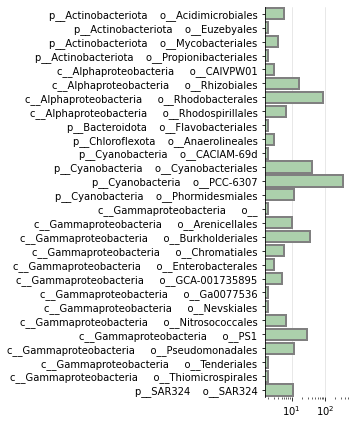

/tmp/ipykernel_10008/2530094444.py:12: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0,500])


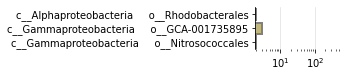

/tmp/ipykernel_10008/2530094444.py:12: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0,500])


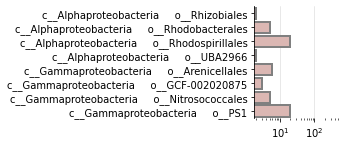

In [109]:
### barplot
for rbset in gb_sort["scluster_bonafide_set"].unique():
    
    table = gb_sort[gb_sort["scluster_bonafide_set"]==rbset]
    height = (len(table)/len(gb_sort)) * 10

    plt.figure(figsize=(1.5,height))
    sns.barplot(x="genome_name", y="display_name", linewidth=2,edgecolor=".5",
                data=table, color=palette[rbset])
    sns.despine(top=True, right=True, bottom=True, left=False)
    plt.xscale("log")
    plt.xlim([0,500])
    for i in [10,100]:
        plt.axvline(i, ls="-", linewidth=0.5, zorder=0, c="lightgrey")
    plt.xlabel("")
    plt.ylabel("")
    plt.savefig(rootdir + "figures/by_form/%s_bar.svg" %(rbset), format="svg",
               dpi=300,  bbox_inches="tight", facecolor="white")
    plt.show()

/tmp/ipykernel_10008/486192482.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["o_index"] = data["sort_name"].map(o_indices)


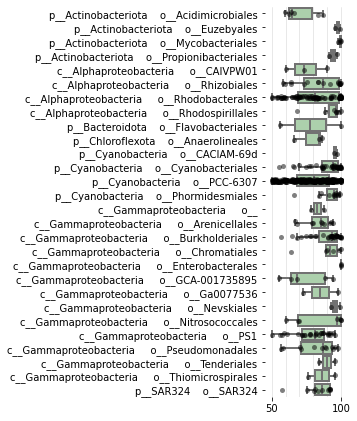

/tmp/ipykernel_10008/486192482.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["o_index"] = data["sort_name"].map(o_indices)


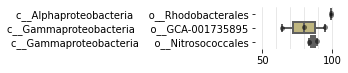

/tmp/ipykernel_10008/486192482.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["o_index"] = data["sort_name"].map(o_indices)


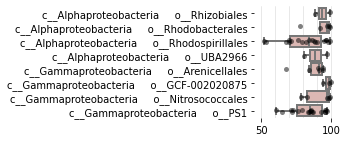

In [110]:
### boxplot
for rbset in gb_sort["scluster_bonafide_set"].unique():
    
    table = gb_sort[gb_sort["scluster_bonafide_set"]==rbset].reset_index()
    height = (len(table)/len(gb_sort)) * 10
    
    o_indices = {row["sort_name"]:key for key, row in table.iterrows()}
    data = merged[(merged["scluster_bonafide_set"]==rbset) & \
                  (merged["sort_name"].isin(table["sort_name"].unique()))]
    data["o_index"] = data["sort_name"].map(o_indices)
    
    plt.figure(figsize=(1.5,height))
    sns.boxplot(x="checkm_completeness", y="display_name", 
                data=data.sort_values("o_index"), 
                color=palette[rbset], linewidth=2, fliersize=0)
    sns.stripplot(x="checkm_completeness", y="display_name", 
                data=data.sort_values("o_index"), 
                color="black", alpha=0.50)
    sns.despine(top=True, right=True, bottom=True, left=True)
    plt.xlim([45,105])
    for i in [50,60,70,80,90, 100]:
        plt.axvline(i, ls="-", linewidth=0.5, zorder=0, c="lightgrey")
    plt.xlabel("")
    plt.ylabel("")
    plt.savefig(rootdir + "figures/by_form/%s_box.svg" %(rbset), format="svg",
               dpi=300,  bbox_inches="tight", facecolor="white")
    plt.show()

In [111]:
# ["deo", "ribp_isomerase", "hps", "phi"] + \
gene_order = ["rubisco_small", "rlp", "prk", "pgk", "gapdh", "fba", "tim", "fbpase", 
              "tkl", "sbpase", "rpi", "rpe"] + \
             ["Ammonia oxidation", "Ammonia oxidation", "Nitrite oxidation", "Aerobic Hydrogen Oxidation", "Aerobic Hydrogen Oxidation"] + \
             ["Sulfide oxidation", "Sulfur oxidation", "Sulfite oxidation", 
              "Sulfite production from org. sulfur", "Thiosulfate oxidation", "Thiosulfate disproportionation"]#, 'Aerobic CO oxidation', 'Formaldehyde oxidation',
             # 'Methanol oxidation', 'Methyl amine -> formaldehyde'] + \
             #['Amylolytic enzymes', 'Cellulose degrading', 'Chitin degrading', 'Endohemicellulases',
             # 'Hemicullulose debranching', 'Other oligosaccharide degrading']

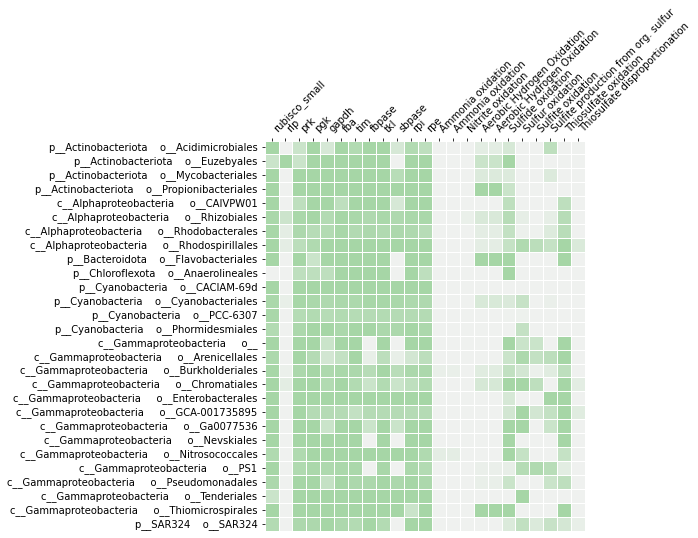

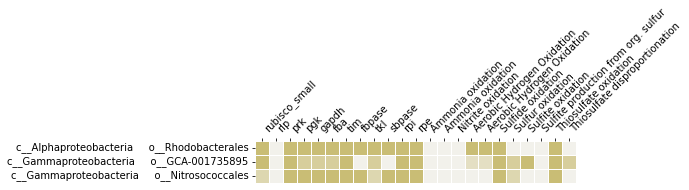

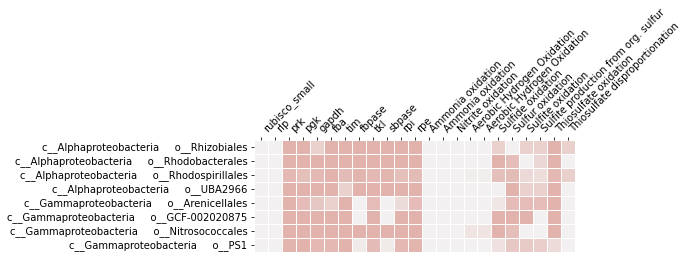

In [113]:
### heatmap
for rbset in gb_sort["scluster_bonafide_set"].unique():
    
    table = gb_sort[gb_sort["scluster_bonafide_set"]==rbset].sort_values("sort_name")
    table.index = table["display_name"]
    table = table.drop(["scluster_bonafide_set",\
                "sort_name", "genome_name", "checkm_completeness", "sort_order"], axis=1)
    height = (len(table)/len(gb_sort)) * 10
    #height=3
    
    plt.figure(figsize=(15,height))
    ax = sns.heatmap(table[gene_order],linewidths=1,cmap=sns.light_palette(palette[rbset], 
                        as_cmap=True), cbar=False, square=True)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0, ha="right")
    plt.xlabel("")
    plt.ylabel("")
    ax.xaxis.tick_top()
    plt.xticks(rotation=45, ha="left")
    plt.savefig(rootdir + "figures/by_form/%s_heatmap.svg" %(rbset), format="svg",
               dpi=300,  bbox_inches="tight", facecolor="white")
    plt.show()
    
    #if rbset in ["I", "I,II_II", "II_II"]:
    #    plt.show()

### by lineage

In [17]:
cmdir(rootdir + "figures/by_lineage")

In [18]:
orders_to_retain = []

for key, row in gb.iterrows():
    total = 0
    for gene in gene_order:
        if row[gene] > 0:
            total+=1
    if total > 2:
        orders_to_retain.append(row["order"])

len(orders_to_retain)

109

In [19]:
lsubset = merged[merged["order"].isin(orders_to_retain)]
lsubset.index = lsubset["genome_name"]

for rbset in lsubset["scluster_bonafide_set"].unique():
    
    for lorder in lsubset[lsubset["scluster_bonafide_set"]==rbset]["order"].unique():
    
        phy, classe, order = [item.split("__")[1] for item in lorder.split(";")]
        table = lsubset[(lsubset["scluster_bonafide_set"]==rbset) & \
                        (lsubset["order"]==lorder)].sort_values("classification")
        
        if len(table) > 1:
            
            height = (len(table)/len(gb_sort)) * 15

            plt.figure(figsize=(15,height))
            ax = sns.heatmap(table[gene_order],linewidths=1,cmap=sns.light_palette(palette[rbset], 
                                as_cmap=True), cbar=False, square=True)
            plt.xticks(rotation=45, ha="right")
            plt.yticks(rotation=0, ha="right")
            plt.xlabel("")
            plt.ylabel("")
            ax.xaxis.tick_top()
            plt.xticks(rotation=45, ha="left")
            plt.savefig(rootdir + "figures/by_lineage/%s_%s_%s.png" %(rbset,phy, order), format="png",
                       dpi=300,  bbox_inches="tight", facecolor="white")

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
